In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
keras = tf.keras
from scipy import stats
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'large'

In [2]:
X_train = pd.read_csv('../data/train_clean.csv', index_col='Date').drop(columns='Unnamed: 0')
X_test = pd.read_csv('../data/test_clean.csv', index_col='Date').drop(columns='Unnamed: 0')

In [3]:
X_train.index = pd.to_datetime(X_train.index)
X_test.index = pd.to_datetime(X_test.index)

In [4]:
X_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)

In [5]:
piv_train = X_train[['Store_Dept', 'Weekly_Sales']].pivot_table('Weekly_Sales', X_train.index,'Store_Dept')
piv_train.dropna(inplace=True, axis=1, thresh=123)
piv_train.fillna(0, inplace=True)
piv_test = X_test[['Store_Dept', 'Weekly_Sales']].pivot_table('Weekly_Sales', X_test.index,'Store_Dept')
piv_test.dropna(inplace=True, axis=1, thresh=123)
piv_test.fillna(0, inplace=True)
piv_train

Store_Dept       1-1      1-11      1-12      1-13      1-14      1-16  \
Date                                                                     
2010-02-05  24924.50  24213.18   8449.54  41969.29  19466.91  10217.55   
2010-02-12  46039.49  21760.75   8654.07  36476.40  18129.02  11873.89   
2010-02-19  41595.55  18706.21   9165.98  37857.68  17491.36  13855.54   
2010-02-26  19403.54  17306.61   9015.37  37467.32  16118.26  12881.02   
2010-03-05  21827.90  19082.90  10239.06  40423.95  18268.78  17129.81   
...              ...       ...       ...       ...       ...       ...   
2012-09-28  18947.81  17242.78  11013.77  39793.41  12037.66  14734.64   
2012-10-05  21904.47  22374.18  10037.09  43746.89  14381.21  11320.41   
2012-10-12  22764.01  21857.09   8983.82  38015.36  11450.64  10525.66   
2012-10-19  24185.27  18259.82  10830.48  38341.15  12035.51   9518.43   
2012-10-26  27390.81  22399.83   8658.41  38512.48  11150.00   9934.63   

Store_Dept      1-17     1-19       1-2     1-20     1-21      1-22      1-23  \
Date                                                                            
2010-02-05  13223.76  1947.05  50605.27  5034.10  8907.63  13623.98  24146.49   
2010-02-12  13403.66  1490.79  44682.74  3697.70  8735.83  14807.95  22812.41   
2010-02-19  13485.61  1722.17  47928.89  4719.89  8949.67  12290.16  21381.85   
2010-02-26  10667.06  1655.32  44292.87  4007.94  8592.42   9295.78  17798.37   
2010-03-05  12657.65  1556.65  48397.98  4215.67  8275.44   8219.49  18993.69   
...              ...      ...       ...      ...      ...       ...       ...   
2012-09-28   7155.75  1385.85  45784.76  3200.54  7737.13   6892.92  14731.92   
2012-10-05   9040.52  1192.58  48577.08  4184.73  7790.01   7821.14  19478.62   
2012-10-12   7908.36  1415.68  42112.67  3126.49  7020.80   8966.16  21024.28   
2012-10-19   7640.43  1247.56  42354.72  3640.07  7614.71   8236.39  17191.96   
2012-10-26   7640.92  1640.81  43134.88  2680.53  8194.63   8236.88  21460.58   

Store_Dept     1-24      1-25      1-26     1-27     1-28     1-29     1-30  \
Date                                                                          
2010-02-05  8272.90  11609.50  11737.12  2293.00  1085.29  7024.95  5491.00   
2010-02-12  8050.24  13268.75  10050.92  2339.50  1008.36  7696.61  5328.50   
2010-02-19  7366.70  10271.25  10547.60  2494.50  1012.09  7966.55  5735.00   
2010-02-26  5630.82  10218.67   8541.14  1666.75   986.07  4972.65  3614.48   
2010-03-05  6885.90  10345.50   8772.65  1467.50  1002.20  5306.70  4360.50   
...             ...       ...       ...      ...      ...      ...      ...   
2012-09-28  4364.69   7685.71   5035.97   948.57   402.73  3515.91  2047.42   
2012-10-05  7322.07  11140.24   8784.99  1492.09   641.70  4288.34  2520.85   
2012-10-12  7733.20  10485.04  12773.34  1536.58   596.37  3465.18  2258.74   
2012-10-19  5355.52   8702.47   7004.13  1841.73   656.45  3739.10  2559.08   
2012-10-26  7106.74  11066.13   7412.16  1712.02   742.48  4077.20  2830.48   

Store_Dept     1-31      1-32     1-33      1-34     1-37       1-38  \
Date                                                                   
2010-02-05  3455.92  11875.84  8589.77  14350.83  3438.16  115564.35   
2010-02-12  3228.96  14700.59  8483.54  12852.83  3450.68   94136.35   
2010-02-19  2652.00  20275.45  7611.35  13006.50  3203.31   98672.59   
2010-02-26  2665.75   8146.57  4814.66  12005.00  2474.99   92755.59   
2010-03-05  2595.80   9907.51  6214.60  12571.50  3647.82  108282.86   
...             ...       ...      ...       ...      ...        ...   
2012-09-28  1060.74   3909.44  4390.19   8972.86  2507.60   75484.17   
2012-10-05  2063.02   5852.15  6775.72  10523.41  2466.90   74894.95   
2012-10-12  1276.81   5238.49  7617.49  11105.36  2482.70   82276.59   
2012-10-19  1529.52   6241.78  5170.49   9544.78  2483.49   68794.43   
2012-10-26  1413.51   5918.47  6313.48   9972.00  2566.42   66526.76   

Store_Dept      1-

In [6]:
def windowize_data(data, n_prev, n_future):
    '''
    returns:
        x: np array with shape (n_predictions, n_prev, 1)
        y: np array with shape (n_predictions, n_future, 1)
    '''
    n_predictions = len(data) - n_prev - n_future +1
    y = data[n_prev:]
    dates = data.index[n_prev:]
#     print(dates[:5])
    # this might be too clever
    y_indices = np.arange(n_future) + np.arange(n_predictions)[:, None]
    y = y[y_indices, None]
    y_dates = dates[y_indices, None]
    x_indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[x_indices, None]
    return x, y, y_dates

def window_multi_groups(data, n_prev, n_future):
    '''
    returns an x and y
    '''
    ncols = data.shape[1]
    n_pred = len(data) - n_prev - n_future +1
    n_total_pred = n_pred * ncols
    x = np.zeros((n_total_pred, n_prev, 1))
    y = np.zeros((n_total_pred, n_future, 1))
    y_dates = np.empty((n_total_pred, n_future, 1),dtype='datetime64[ns]')
    for i in range(ncols):
        start = i * n_pred
        stop = start + n_pred
#         print(start,stop)
        x[start:stop, :, :], y[start:stop, :, :], y_dates[start:stop, :, :] = windowize_data(data.iloc[:,i], n_prev, n_future)
#         x, y = windowize_data(data.iloc[:,i], n_prev, n_future)
    return x, y, y_dates

In [7]:
n_prev = 54
n_future = 10
# 6 into future

# X_train_window, y_train_window, y_train_dates = window_multi_groups(piv_train, n_prev, n_future)
# X_test_window, y_test_window, y_test_dates = window_multi_groups(piv_test, n_prev, n_future)

X_train_window, y_train_window, y_train_dates = windowize_data(piv_train.iloc[:,2], n_prev, n_future)
# X_test_window, y_test_window, y_test_dates = windowize_data(piv_test, n_prev, n_future)

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(y_test_window.index, y_pred, 'b.-', label='predictions', lw=0.5)
ax.plot(y_test_window.index, y_test_window, 'r.', label='actual')
ax.legend();

In [88]:
X_train_window[0], y_train_window[0]

(array([[24924.5 ],
        [46039.49],
        [41595.55],
        [19403.54],
        [21827.9 ],
        [21043.39],
        [22136.64],
        [26229.21],
        [57258.43],
        [42960.91],
        [17596.96],
        [16145.35],
        [16555.11],
        [17413.94],
        [18926.74],
        [14773.04],
        [15580.43],
        [17558.09],
        [16637.62],
        [16216.27],
        [16328.72],
        [16333.14],
        [17688.76],
        [17150.84],
        [15360.45],
        [15381.82],
        [17508.41],
        [15536.4 ],
        [15740.13],
        [15793.87],
        [16241.78],
        [18194.74],
        [19354.23],
        [18122.52],
        [20094.19],
        [23388.03],
        [26978.34],
        [25543.04],
        [38640.93],
        [34238.88],
        [19549.39],
        [19552.84],
        [18820.29],
        [22517.56],
        [31497.65],
        [44912.86],
        [55931.23],
        [19124.58],
        [15984.24],
        [17359.7 ],


In [216]:
y_train_window.shape, y_pred.shape

((80, 10, 1), (80, 10))

In [306]:

model = keras.Sequential(name='Encoder-Decoder-LSTM')
model.add(keras.layers.LSTM(64, input_shape=(n_prev, 1), return_sequences=False, activation='relu')) # 1 is num of variables to predict on
model.add(keras.layers.RepeatVector(n_future))
model.add(keras.layers.LSTM(64, return_sequences=True, activation='relu'))
# model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(1, activation='linear')))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), loss='mape')

In [288]:

model = keras.Sequential(name='Stacked-LSTM')
model.add(keras.layers.LSTM(64, input_shape=(n_prev, 1), return_sequences=True)) # 1 is num of variables to predict on
model.add(keras.layers.LSTM(64, return_sequences=False))
model.add(keras.layers.Dense(n_future, activation='linear'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), loss='mape')

In [205]:
model = keras.Sequential(name='SimpleCNN')
model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_prev, 1)))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(n_future, activation='linear'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mape')

In [310]:
model = keras.Sequential(name='WaveNet')
model.add(keras.layers.InputLayer(input_shape=(n_prev, 1)))
for rate in (1, 2, 4, 8) * 2: 
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal", activation="relu", dilation_rate=rate)) 
model.add(keras.layers.Conv1D(filters=15, kernel_size=1)) 
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_future, activation='linear'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), loss='mape')

In [311]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mape')

In [312]:
model.summary()

Model: "WaveNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_159 (Conv1D)          (None, 54, 20)            60        
_________________________________________________________________
conv1d_160 (Conv1D)          (None, 54, 20)            820       
_________________________________________________________________
conv1d_161 (Conv1D)          (None, 54, 20)            820       
_________________________________________________________________
conv1d_162 (Conv1D)          (None, 54, 20)            820       
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 54, 20)            820       
_________________________________________________________________
conv1d_164 (Conv1D)          (None, 54, 20)            820       
_________________________________________________________________
conv1d_165 (Conv1D)          (None, 54, 20)            820 

In [314]:
# checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
model.fit(X_train_window, y_train_window, epochs=10, batch_size=1, validation_split=0.2) 



Epoch 1/10
64/64 [==============================] - 0s 4ms/step - loss: 9.9411 - val_loss: 11.0567
Epoch 2/10
64/64 [==============================] - 0s 4ms/step - loss: 9.5544 - val_loss: 9.7594
Epoch 3/10
64/64 [==============================] - 0s 4ms/step - loss: 9.2337 - val_loss: 11.5492
Epoch 4/10
64/64 [==============================] - 0s 4ms/step - loss: 9.1266 - val_loss: 10.0311
Epoch 5/10
64/64 [==============================] - 0s 4ms/step - loss: 9.9333 - val_loss: 10.4015
Epoch 6/10
64/64 [==============================] - 0s 4ms/step - loss: 8.8542 - val_loss: 10.2569
Epoch 7/10
64/64 [==============================] - 0s 4ms/step - loss: 8.9504 - val_loss: 10.0386
Epoch 8/10
64/64 [==============================] - 0s 4ms/step - loss: 9.6701 - val_loss: 12.7432
Epoch 9/10
64/64 [==============================] - 0s 4ms/step - loss: 9.4331 - val_loss: 12.1003
Epoch 10/10
64/64 [==============================] - 0s 4ms/step - loss: 8.8186 - val_loss: 10.5658


In [ ]:
refit model multiple times - more a test of robust vs finicky

In [315]:
y_pred = model.predict(X_train_window)

In [130]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])



In [225]:
y_pred[-1]

array([11056.067, 11406.413, 11723.263, 11112.966, 10255.05 , 10943.829,
       11644.08 , 11216.079, 10294.311, 10636.529], dtype=float32)

In [234]:
y_train_window.shape

(80, 10, 1)

In [224]:
y_train_dates[-1]

array([['2012-08-24T00:00:00.000000000'],
       ['2012-08-31T00:00:00.000000000'],
       ['2012-09-07T00:00:00.000000000'],
       ['2012-09-14T00:00:00.000000000'],
       ['2012-09-21T00:00:00.000000000'],
       ['2012-09-28T00:00:00.000000000'],
       ['2012-10-05T00:00:00.000000000'],
       ['2012-10-12T00:00:00.000000000'],
       ['2012-10-19T00:00:00.000000000'],
       ['2012-10-26T00:00:00.000000000']], dtype='datetime64[ns]')

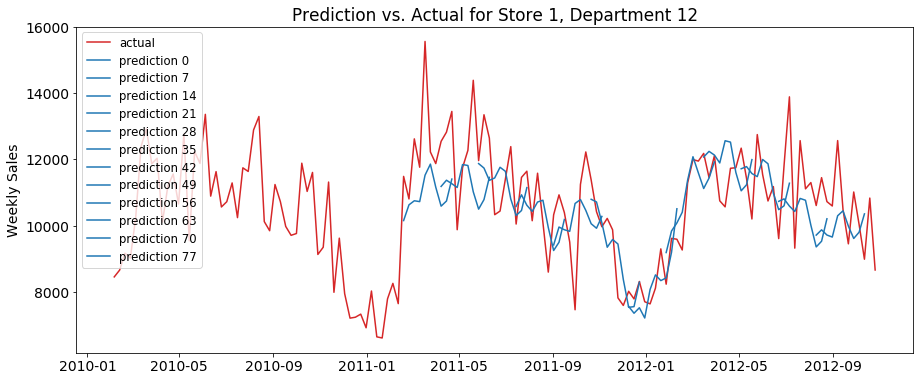

In [316]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(piv_train.iloc[:,2], label='actual', color='tab:red')
for i in range(0,y_train_window.shape[0],7):
# for i in range(6):
    ax.plot(y_train_dates.reshape(-1,10)[i], y_pred[i], label=f'prediction {i}', color='tab:blue')
#     print(y_pred[0][i])
# ax.plot(piv_train.iloc[:,2], label='actual', color='tab:blue')


# ax.plot(y_test_dates.reshape(-1,10)[79], y_test_window.reshape(-1,10)[79::80].sum(axis=0), label='actual')
# ax.plot(y_test_window.index, y_test_window, 'r.-', label='actual')
ax.legend()
ax.set_title('Prediction vs. Actual for Store 1, Department 12')
ax.set_ylabel('Weekly Sales');

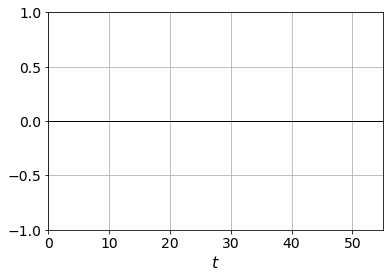

In [114]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_prev, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_prev, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_prev + 1, -1, 1])


plot_series(X_train_window[col, :, 0], y_train_window[col, 0],
                y_label=("$x(t)$" if col==0 else None))

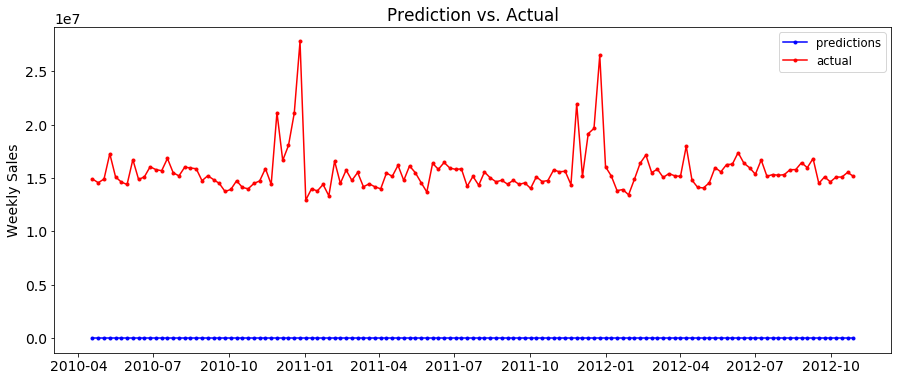

In [25]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(y_test_window.index, y_pred, 'b.-', label='predictions')
ax.plot(y_test_window.index, y_test_window, 'r.-', label='actual')
ax.legend()
ax.set_title('Prediction vs. Actual')
ax.set_ylabel('Weekly Sales');

In [ ]:
y_pred

In [18]:
X_test_window

array([[[16949557.13000003],
        [15527423.02000002],
        [14904971.82999999],
        ...,
        [14034991.80999999],
        [16483324.48      ],
        [15761521.46999999]],

       [[15527423.02000002],
        [14904971.82999999],
        [14857999.26999999],
        ...,
        [16483324.48      ],
        [15761521.46999999],
        [14906580.86      ]],

       [[14904971.82999999],
        [14857999.26999999],
        [15453439.02999999],
        ...,
        [15761521.46999999],
        [14906580.86      ],
        [14555150.93000003]],

       ...,

       [[15310966.89999999],
        [15771052.76000002],
        [15789121.06999999],
        ...,
        [15101210.08000001],
        [14635362.29999998],
        [15089821.07      ]],

       [[15771052.76000002],
        [15789121.06999999],
        [16433747.40999999],
        ...,
        [14635362.29999998],
        [15089821.07      ],
        [15084852.99999999]],

       [[15789121.06999999],
        [1643